In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

from evil.irl.irl_multi_discr import IRLPlus
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".20"
import pickle
import evosax

import jax
import jax.numpy as jnp
from evil.training.wrappers import TremblingHandWrapper
from evil.utils.env_utils import get_env
from evil.utils.plot import setup_plot
from evil.utils.utils import (
    RewardNetwork,
    RewardWrapper,
    get_irl_config,
    get_observation_size,
)
from evil.training.ppo_v2_cont_irl import (
    make_train as make_train_cont,
)
from evil.configs.hyperparam_search_new_shaping import run_config as OUTER_CONFIG
from evil.training.ppo_v2_irl import make_train
import matplotlib.pyplot as plt
import numpy as np

def train_fn_irl_reward(rng, env, make_train_fn, es_training_config, tremble=0.0):
    tremble_env = TremblingHandWrapper(env, p_tremble=tremble)
    train_fn_irl_reward = make_train_fn(
        config=es_training_config,
        env=tremble_env,
        env_params=env_params,
        runner_state_start=None,
        log_timestep_returns=True,
        return_obs_and_actions=False,
    )
    train_out_irl_reward = jax.jit(train_fn_irl_reward)(rng)
    irl_returns = train_out_irl_reward["metrics"]["timestep_returned_episode_returns"]
    return irl_returns
                
def train_irl(train_irl_class, rng):
    (
        (multi_discr_last_runner_state, multi_discr_last_discr),
        multi_discr_irl_train_metrics,
    ) = train_irl_class.train(rng, env_params, None, return_buffer=False)
    multi_discr_irl_train_metrics = multi_discr_irl_train_metrics["returned_episode_real_returns"]
    return multi_discr_irl_train_metrics

TREMBLE = 0.
es_config = OUTER_CONFIG
es_config["env"] = "gridworld"
env, env_params, original_training_config = get_env(env_name=es_config["env"])
es_config, es_training_config = get_irl_config(es_config, original_training_config)
print(es_training_config)
es_training_config["NORMALIZE_OBS"] = False
es_training_config["NORMALIZE_REWARD"] = True
if es_training_config["DISCRETE"]:
        action_num = env.action_space(env_params).n
        observation_shape = env.observation_space(env_params).shape[0]
        make_train = make_train
else:
    action_num = env.action_space(env_params).shape[0]
    make_train = make_train_cont
    observation_shape = get_observation_size(env, env_params)[0]
shaping_net = RewardNetwork(
    hsize=es_config["reward_net_hsize"],
    activation_fn=es_config["reward_net_activation_fn"],
    sigmoid=False,
)
init_shap_params = shaping_net.init(jax.random.PRNGKey(0), jnp.zeros(observation_shape))
param_reshaper = evosax.ParameterReshaper(init_shap_params)

home_dir = "/home/silvias/docker/jaxirl/"

NUM_UPDATES = es_training_config["ORIG_NUM_UPDATES"]

2024-05-01 12:21:57.560696: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Visible devices [cuda(id=0)]
Visible devices [cuda(id=0)]
{'irl_plus': True, 'log_gen_every': 2, 'reward_net_hsize': [64, 64], 'reward_net_sigmoid': False, 'wandb_log': True, 'plot': False, 'train_rng': 'DIFFERENT_IN_PAIRS', 'save_to_file': True, 'env': 'gridworld', 'reward_normalize': True, 'reward_all_normalize': False, 'obs_normalize': True, 'num_eval_steps': 1000, 'num_expert_eval_envs': 50, 'loss': 'AUC_TWO_STEP', 'seed': 1, 'seeds': 5, 'dual': False, 'run_test': False, 'num_eval_envs': 50, 'inner_lr_linear': False, 'inner_lr': 0.0003, 'inner_steps': 10, 'generations': 600, 'real_reward': 'IRL_STATE', 'reward_type': 'SHAPING_STATE', 'lrate_init': 0.01, 'popsize': 64, 'reward_net_activation_fn': 'tanh', 'train_restart': 'NONE', 'restart_top_perc': 1.0, 'max_buffer_size': 1, 'discr_loss': 'bce', 'alpha': 0, 'discr_l2_loss': 0.0, 'discr_batch_size': 4096, 'irl_lrate_init': 0.008, 'discr_schedule_type': 'linear', 'discr_trans_decay': 800, 'discr_final_lr_diff': 2, 'discr_updates_every

In [2]:
import jaxirl
import importlib
importlib.reload(jaxirl.utils.env_utils)
importlib.reload(jaxirl.utils.utils)
import jaxirl.utils.env_utils
import jaxirl.utils.utils
from evil.utils.utils import get_expert_obsv_and_actions
from evil.training.ppo_v2_cont_irl import make_train as make_train_cont, eval as eval_cont
from evil.training.ppo_v2_irl import make_train, eval, get_network

es_config["expert_num_seeds"] = 1
es_config["wandb_log"] = False
es_config["num_eval_steps"] = 20

if es_training_config["DISCRETE"]:
    make_train_fn, eval_fn = make_train, eval
else:
    make_train_fn, eval_fn = make_train_cont, eval_cont
print(original_training_config)
original_training_config["NUM_UPDATES"] = 5
original_training_config["NUM_STEPS"] = 20
# TRAIN EXPERT AGENT
true_env = RewardWrapper(
    env=env,
    env_params=env_params,
    reward_network=None,
    rew_network_params=None,
    shaping_network=None,
    shap_network_params=None,
    training_config=original_training_config,
)
trained_expert_path = "/home/silvias/docker/jaxirl/experts/gridworld_1.pkl"
(
    expert_obsv_complete,
    expert_actions,
    (expert_obsv, expert_dones, expert_rewards),
    original_returns,
    last_return,
    train_expert_norm_stats,
) = get_expert_obsv_and_actions(
    true_env,
    env_params,
    es_config,
    make_train_fn,
    eval_fn,
    original_training_config,
    trained_expert_path,
)
with open(trained_expert_path, "rb") as f:
    expert_train_out = pickle.load(f)
    expert_params = expert_train_out["expert_params"]
    expert_params = jax.tree_map(lambda x: x[0], expert_params)

{'LR': 0.001, 'NUM_ENVS': 16, 'NUM_STEPS': 10, 'NUM_UPDATES': 100, 'ORIG_NUM_UPDATES': 100, 'TOTAL_TIMESTEPS': 16000, 'UPDATE_EPOCHS': 10, 'NUM_MINIBATCHES': 10, 'GAMMA': 0.99, 'GAE_LAMBDA': 0.95, 'CLIP_EPS': 0.2, 'ENT_COEF': 0.01, 'VF_COEF': 0.5, 'MAX_GRAD_NORM': 0.5, 'ACTIVATION': 'tanh', 'ENV_NAME': 'gridworld', 'ANNEAL_LR': False, 'DEBUG': False, 'NORMALIZE_ENV': False, 'DISCRETE': True, 'NORMALIZE_REWARD': True, 'NORMALIZE_OBS': True, 'NORMALIZE_ALL_REWARD': False}
Trained TRAIN expert positional FOUND
Expert last return [0.16432293 0.43828127 0.70234376 0.9208334  0.98580736 0.9960938
 0.99218756 0.9851563  0.99505216 0.9977865 ]


/tmp/ipykernel_679659/509060378.py:52: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  expert_params = jax.tree_map(lambda x: x[0], expert_params)


In [3]:
run_shaped = "distinctive-waterfall-4512"
shap_params_init = shaping_net.init(
    jax.random.PRNGKey(0), jnp.zeros(observation_shape)
)
shap_params = jax.tree_map(lambda x: x.reshape(1, *x.shape), shap_params_init)
with open(
    f"{home_dir}/rewards/{es_config['env']}/{run_shaped}_{400}.pkl",
    "rb",
) as f:
    info = pickle.load(f)
    new_shap_params = param_reshaper.reshape_single(info["state"].mean)
    new_shap_params = jax.tree_map(
        lambda x: x.reshape(1, *x.shape), new_shap_params
    )
    shap_params = jax.tree_map(
        lambda x, y: jnp.concatenate((x, y), axis=0),
        shap_params,
        new_shap_params,
    )
shap_params = jax.tree_map(lambda x: x[1], shap_params)
jax.tree_map(lambda x: x.shape, shap_params)

/tmp/ipykernel_679659/3608447597.py:5: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  shap_params = jax.tree_map(lambda x: x.reshape(1, *x.shape), shap_params_init)
/tmp/ipykernel_679659/3608447597.py:12: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  new_shap_params = jax.tree_map(
/tmp/ipykernel_679659/3608447597.py:15: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  shap_params = jax.tree_map(
/tmp/ipykernel_679659/3608447597.py:20: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  shap_params = jax.tree_map(lambda x: x[1], shap_params)
/tmp/ipykernel_679659/3608447597.py:21: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (

{'params': {'Dense_0': {'bias': (64,), 'kernel': (5, 64)},
  'Dense_1': {'bias': (64,), 'kernel': (64, 64)},
  'vals': {'bias': (1,), 'kernel': (64, 1)}}}

In [7]:
shaped_env = RewardWrapper(
    env=env,
    env_params=env_params,
    reward_network=shaping_net,
    rew_network_params=shap_params,
    # shaping_network=shaping_net,
    # shap_network_params=shap_params,
    shaping_network=None,
    shap_network_params=None,
    training_config=original_training_config,
)
agent_network = get_network(
    env,
    env_params,
    es_training_config,
)
expert_obsv, expert_actions, expert_shaped_rewards, expert_dones = eval_fn(
    num_envs=50, 
    num_steps=10, 
    env=shaped_env, 
    env_params=env_params, 
    agent_params=expert_params, 
    rng=jax.random.PRNGKey(0), 
    network=agent_network, 
    return_reward=True
)
expert_obsv = expert_obsv.reshape(-1, expert_obsv.shape[-1])
expert_actions = expert_actions.reshape(-1)
expert_shaped_rewards = expert_shaped_rewards.reshape(-1)
expert_dones = expert_dones.reshape(-1)

In [21]:
expert_obsv.shape

(10, 50, 5)

In [22]:
from evil.envs.gridworld import get_state_dict_from_obs

obs, state = env.reset(jax.random.PRNGKey(0), env_params)
print(state.pos, state.goals)
obs, state, reward, done, _ = env.step(jax.random.PRNGKey(0), state, 0, env_params)
print(state.pos, state.goals, state.found, reward)
obs, state, reward, done, _ = env.step(jax.random.PRNGKey(0), state, 1, env_params)
print(state.pos, state.goals, state.found, reward, done)
obs, state, reward, done, _ = env.step(jax.random.PRNGKey(0), state, 1, env_params)
print(state.pos, state.goals, state.found, reward, done)
obs, state, reward, done, _ = env.step(jax.random.PRNGKey(0), state, 3, env_params)
print(state.pos, state.goals, state.found, reward, done)
obs, state, reward, done, _ = env.step(jax.random.PRNGKey(0), state, 3, env_params)
print(state.pos, state.goals, state.found, reward, done)

[1 2] [[0 4]]
[0 2] [[0 4]] [False] 0.0
[0 3] [[0 4]] [False] 0.0 False
[0 4] [[0 4]] [ True] 1.0 False
[3 2] [[0 4]] [False] 0.0 True
[3 1] [[0 4]] [False] 0.0 False


In [3]:
obs.shape

(75,)

In [5]:
print(expert_obsv.shape)
print(expert_rewards.shape)
expert_obsv = expert_obsv.reshape(-1, expert_obsv.shape[-1])
expert_rewards = expert_rewards.reshape(-1)
expert_dones = expert_dones.reshape(-1)
print(expert_rewards.shape)

(500, 5)
(50, 20)
(1000,)


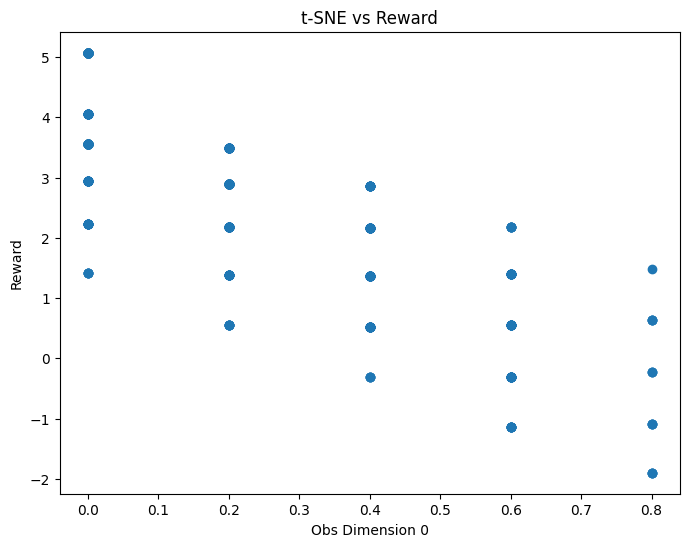

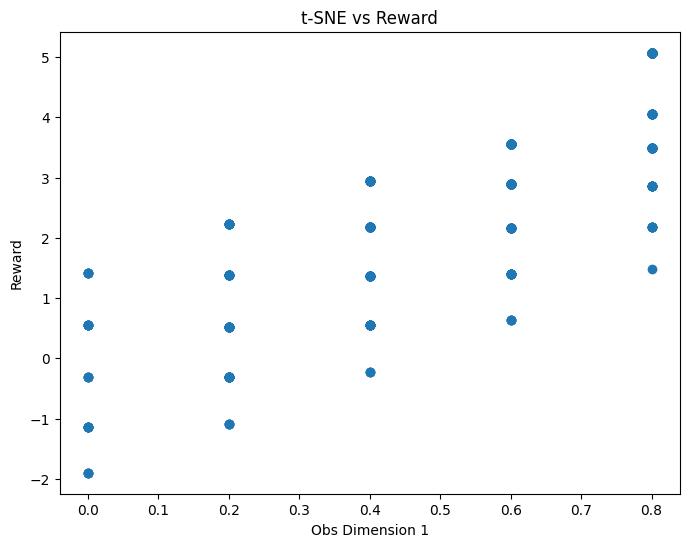

In [27]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# data = np.array(expert_obsv[::50])
data=expert_obsv

# Reduce dimensionality with t-SNE (3D embedding)
# tsne = TSNE(n_components=3)
# tsne_data = tsne.fit_transform(data)

# Extract the 3D components
for i in range(2):
    # tsne_x = tsne_data[:, i]
    x = data[:, i]
    # tsne_y = tsne_data[:, 1]

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(8, 6))
    # ax = fig.add_subplot(111, projection='3d')
    ax = fig.add_subplot(111)
    # ax.scatter(tsne_x[::5], tsne_y[::5], data[::5, 13])
    ax.scatter(x, expert_shaped_rewards)
    # shaped_reward = shaping_net.apply(shap_params, data)
    # prev_done = expert_dones[:-1]
    # done = jnp.concatenate((jnp.array([0]), expert_dones[2:]))
    # shaped_reward_all = expert_rewards[:-1] - (shaped_reward.reshape(-1)[:-1] * (1-prev_done)) * 0.99 + (shaped_reward.reshape(-1)[1:] * (1-done))
    # ax.scatter(x[:-1], shaped_reward_all)

    # Customize the plot (optional)
    ax.set_xlabel(f"Obs Dimension {i}")
    # ax.set_ylabel("t-SNE Dimension 2")
    ax.set_ylabel("Reward")
    ax.set_title("t-SNE vs Reward")

    plt.show()

In [ ]:
import seaborn as sns

# sns.histplot(data[::5, 13], bins=100, label="Reward", stat='probability', alpha=0.7, element="step")
# sns.scatterplot(x=data[::5, 13][:-1]-data[::5, 13][1:], y=shaped_reward.reshape(-1)[:-1], label="Shaped Term", alpha=0.7)
# shaped_reward_all = expert_rewards[::500][:-1] - shaped_reward.reshape(-1)[:-1] * 0.999 + shaped_reward.reshape(-1)[1:]
# sns.histplot(x=expert_rewards[::50][::5][:-1], y=shaped_reward_all)
# sns.histplot(x=expert_rewards, y=expert_shaped_rewards)
# sns.histplot(x=expert_obsv[::50][:-1, 3], y=expert_rewards[::50][:-1], color="orange")
# sns.histplot(x=expert_rewards[::50][:-1], y=shaped_reward_all)
# sns.histplot(x=expert_rewards[::50][:-1], y=shaped_reward_all)
plt.legend()
plt.xlabel("Reward")
plt.ylabel("Shaped Reward")
plt.title("Rewards vs Shaped Rewards")
plt.show()

In [27]:
expert_obsv.shape, expert_shaped_rewards.shape

((500, 5), (500,))

In [55]:
import matplotlib
from matplotlib import font_manager as fm, pyplot as plt
font_files = fm.findSystemFonts("/home/silvias/docker/jaxirl/fonts/")
for font_file in font_files:
    fm.fontManager.addfont(font_file)
matplotlib.rc("font", family="Palatino Linotype")
sns.set(font="serif", font_scale=1.4)
sns.set_style(
    "white",
    {
        "font.family": "serif",
        "font.weight": "normal",
        "font.serif": ["Times", "Palatino", "serif"],
        "axes.facecolor": "white",
        "lines.markeredgewidth": 1,
    },
)

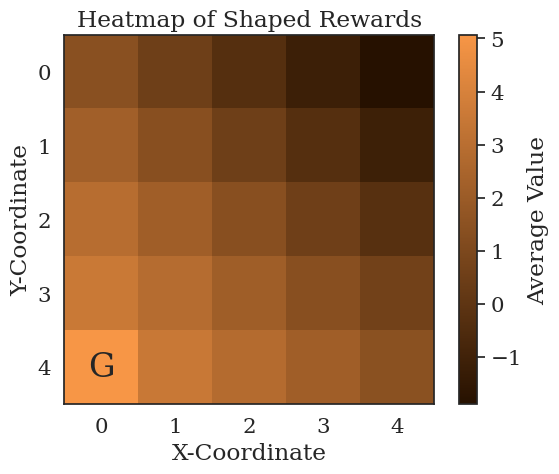

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

# Sample data (replace with your actual arrays)
x_coords = (expert_obsv[:, 0]*5).astype(int)
y_coords = (expert_obsv[:, 1]*5).astype(int)
values = expert_shaped_rewards

# Reshape the values array to match the coordinate grid
grid_shape = (5,5)
value_grid = np.zeros(grid_shape)
for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    value_grid[y, x] = values[i]

# Calculate the average for each point (non-zero values)
average_grid = np.zeros(grid_shape)
count_grid = np.zeros(grid_shape)
for y in range(grid_shape[0]):
    for x in range(grid_shape[1]):
        if value_grid[y, x] != 0:
            average_grid[y, x] = np.mean(value_grid[y, x])
            count_grid[y, x] = 1  # Optional: count non-zero elements

# Create the heatmap
# colors_list = ["#e76e0a", "#f57a15", "#f6882e", "#f79646", "#f8a45e", "#f9b277", "#fac08f"]
cs = [(0, "#261100"), (1, "#F79646")]

# Create a LinearSegmentedColormap object
cmap = colors.LinearSegmentedColormap.from_list("", cs)
# colors_list = ["#fac08f", "#f9b277", "#f8a45e", "#f79646", "#f6882e", "#f57a15", "#e76e0a"]
# cmap = colors.ListedColormap(colors_list)
# "#008000"
plt.imshow(average_grid, cmap=cmap)

# Customize the plot (optional)
plt.colorbar(label="Average Value")
plt.xticks(np.arange(len(np.unique(x_coords))), np.unique(x_coords))
plt.yticks(np.arange(len(np.unique(y_coords))), np.unique(y_coords))
plt.xlabel("X-Coordinate")
plt.ylabel("Y-Coordinate")
plt.title("Heatmap of Shaped Rewards")
plt.text(
    0,  # Replace with the x-coordinate
    4,  # Replace with the y-coordinate
    "G",
    ha="center",
    va="center",
    fontsize=24,
    # bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.3"),
)
# Optionally show count instead of average (if relevant)
# plt.imshow(count_grid, cmap="viridis")

plt.show()

In [51]:
xy_coords = jnp.meshgrid(np.arange(5), np.arange(5))
xy_coords

[Array([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]], dtype=int32),
 Array([[0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4]], dtype=int32)]

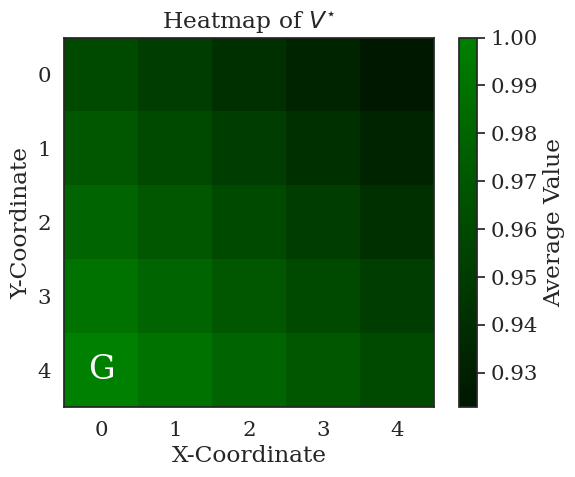

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual arrays)
xy_coords = jnp.meshgrid(np.arange(5), np.arange(5))
x_coords = xy_coords[0].reshape(-1)
y_coords = xy_coords[1].reshape(-1)
values = jax.vmap(lambda x, y: 0.99**(x+(4-y)))(x_coords, y_coords)

# Reshape the values array to match the coordinate grid
grid_shape = (5,5)
value_grid = np.zeros(grid_shape)
for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    value_grid[y, x] = values[i]

# Calculate the average for each point (non-zero values)
average_grid = np.zeros(grid_shape)
count_grid = np.zeros(grid_shape)
for y in range(grid_shape[0]):
    for x in range(grid_shape[1]):
        if value_grid[y, x] != 0:
            average_grid[y, x] = np.mean(value_grid[y, x])
            count_grid[y, x] = 1  # Optional: count non-zero elements

# Create the heatmap
# colors_list = ["#003400", "#004d00", "#006700", "#008000", "#009a00", "#00b300", "#00cd00"]
cs = [(0, "#001700"), (1, "#008000")]

# Create a LinearSegmentedColormap object
cmap = colors.LinearSegmentedColormap.from_list("", cs)
# colors_list = ["#00cd00", "#00b300", "#009a00", "#008000", "#006700", "#004d00", "#003400"]
# cmap = colors.ListedColormap(colors_list)
plt.imshow(average_grid, cmap=cmap)

# Customize the plot (optional)
plt.colorbar(label="Average Value")
plt.xticks(np.arange(len(np.unique(x_coords))), np.unique(x_coords))
plt.yticks(np.arange(len(np.unique(y_coords))), np.unique(y_coords))
plt.xlabel("X-Coordinate")
plt.ylabel("Y-Coordinate")
plt.title("Heatmap of $V^{\star}$")
plt.text(
    0,  # Replace with the x-coordinate
    4,  # Replace with the y-coordinate
    "G",
    ha="center",
    va="center",
    fontsize=24,
    color="white"
    # bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.3"),
)
# Optionally show count instead of average (if relevant)
# plt.imshow(count_grid, cmap="viridis")

plt.show()

Text(0.5, 0, 'Distance to Goal')

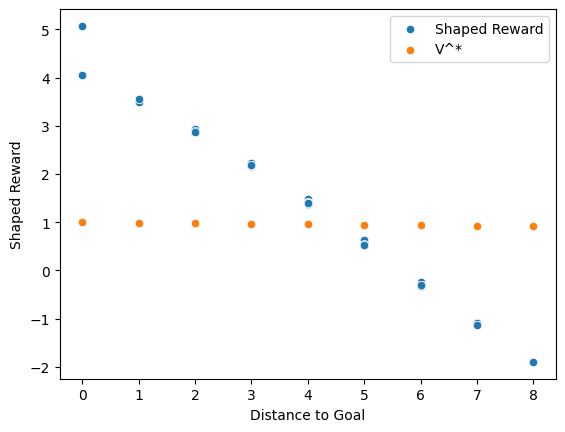

In [39]:
import seaborn as sns
distance = abs(expert_obsv[:, 0] - expert_obsv[:, 2]) + abs(expert_obsv[:, 1] - expert_obsv[:, 3])
# sns.scatterplot(x=distance*5, y=expert_shaped_rewards)
sns.scatterplot(x=distance*5, y=expert_shaped_rewards, label="Shaped Reward")
v_start = 0.99**jnp.arange(0,9,1)
sns.scatterplot(x=jnp.arange(0,9,1), y=v_start, label="V^*")
plt.ylabel("Shaped Reward")
plt.xlabel("Distance to Goal")

In [4]:
trained_standard_expert_path = f"{home_dir}/experts/{es_config['env']}.pkl"
with open(trained_standard_expert_path, "rb") as f:
    expert_train_out = pickle.load(f)
    print(expert_train_out.keys())
    try:
        data_mean = expert_train_out["norm_mean"]
        data_var = expert_train_out["norm_var"]
    except:
        data_mean = jnp.zeros(env.observation_size[0])
        data_var = jnp.ones(env.observation_size[0])
# shaped_reward = shaping_net.apply(shap_params, (data - data_mean) / jnp.sqrt(data_var + 1e-8))

dict_keys(['returns', 'final_return', 'expert_obsv', 'expert_actions', 'norm_mean', 'norm_var'])


In [51]:
shaped_env = RewardWrapper(
    env=env,
    env_params=env_params,
    reward_network=None,
    rew_network_params=None,
    shaping_network=shaping_net,
    shap_network_params=shap_params,
    training_config=original_training_config,
    data_stats=(data_mean, data_var),
)
train_fn = make_train_cont(
    config=original_training_config,
    env=shaped_env,
    env_params=env_params,
    runner_state_start=None,
    log_timestep_returns=True,
    return_obs_and_actions=False,
)
res = jax.jit(train_fn)(jax.random.PRNGKey(0))